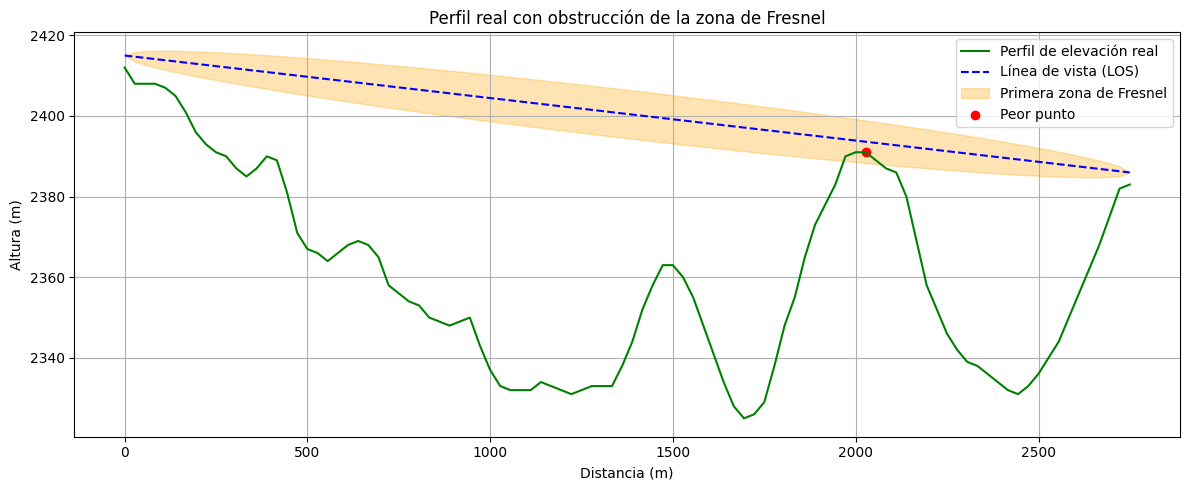

Index Peor Fresnel: 73
Radio de Fresnel en ese punto = 5.29 m
Espacio libre de la zona fresnel = 2.62 m
--------------------------------------------------
Frecuencia Promedio = 5.710 GHz
Distancia de Tx al obstaculo = 2026.95 m
Distancia de Rx al obstaculo = 721.93 m
Distancia total = 2.75 Km
Peor Fresnel = 0.49F1
Azimut = 16.44º
Espacio Libre = 116.36dB
Pérdidas = 123.59 dB
Angulo de Elevación = -0.60º
Obstrucción (difracción): 0.539 dB
Campo E = 77.988 dBμV/m
Despeje a = 2.027 Km
Nivel Rx = -70.329 dBm
Nivel Rx = 68.165 μV
Rx Relativo: 36.67 dB
Estadísticas: 6.70 dB


In [ ]:
import requests
import math
import time
import matplotlib.pyplot as plt

# ------------------ FUNCIONES BÁSICAS ------------------

def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def fresnel_radius(d1, d2, f_ghz, n=1):
    C = 3e8  # Velocidad de la luz
    if d1 == 0 or d2 == 0:
        return 0
    lambda_m = C / (f_ghz * 1e9)
    return math.sqrt(n * lambda_m * d1 * d2 / (d1 + d2))

def obtener_perfil_elevacion(lat1, lon1, lat2, lon2, n_puntos=100, dataset="mapzen"):
    lats = [lat1 + i * (lat2 - lat1) / (n_puntos - 1) for i in range(n_puntos)]
    lons = [lon1 + i * (lon2 - lon1) / (n_puntos - 1) for i in range(n_puntos)]
    elevaciones = []
    batch_size = 100

    for i in range(0, n_puntos, batch_size):
        batch_lats = lats[i:i + batch_size]
        batch_lons = lons[i:i + batch_size]
        locations = "|".join([f"{lat},{lon}" for lat, lon in zip(batch_lats, batch_lons)])
        url = f"https://api.opentopodata.org/v1/{dataset}?locations={locations}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            elevaciones.extend([result["elevation"] for result in data["results"]])
        else:
            print(f"Error al consultar batch {i // batch_size + 1}")
            elevaciones.extend([None] * len(batch_lats))
        time.sleep(1)

    return list(zip(lats, lons, elevaciones))

def calcular_distancias_acumuladas(perfil):
    distancias = [0.0]
    for i in range(1, len(perfil)):
        lat1, lon1 = perfil[i - 1][:2]
        lat2, lon2 = perfil[i][:2]
        d = haversine(lat1, lon1, lat2, lon2)
        distancias.append(distancias[-1] + d)
    return distancias

# ------------------ LÓGICA DE ANÁLISIS ------------------

def calcular_los_line(elevaciones, tx_height, rx_height):
    return [
        elevaciones[0] + tx_height + i * (elevaciones[-1] + rx_height - (elevaciones[0] + tx_height)) / (len(elevaciones) - 1)
        for i in range(len(elevaciones))
    ]
    
def calcular_obstruccion_db(h, r):
    if r == 0:
        return 0
    v = math.sqrt(2) * h / r
    if v <= -0.78:
        return 0  # pérdida despreciable
    else:
        return 6.9 + 20 * math.log10(math.sqrt((v - 0.1)**2 + 1) + v - 0.1)

def detectar_peor_fresnel(elevaciones, los_line, distancias, freq_ghz):
    global peores_puntos
    peores_puntos = []
    for i in range(1, len(elevaciones) - 1):
        d1 = distancias[i]
        d2 = distancias[-1] - d1
        r_fresnel = fresnel_radius(d1, d2, freq_ghz)
        centro_fresnel = los_line[i]
        borde_inferior = centro_fresnel - r_fresnel
        elevacion_terreno = elevaciones[i]
        #print(f"Index: {i}, Distancia: {d1}, Distancia entre LOS y Elevacion Terreno: {centro_fresnel-elevacion_terreno}")
        if elevacion_terreno >= borde_inferior:
            # penetracion = elevacion_terreno - borde_inferior
            penetracion = los_line[i] - elevacion_terreno
            pct_obstruccion = penetracion / r_fresnel
            #pct_obstruccion = r_fresnel - penetracion
            
            h = elevacion_terreno - los_line[i]
            #print(h)
            obstruccion_db = calcular_obstruccion_db(h, r_fresnel)
            #print("Index: " + str(i) + ", Centro_LOS: " + str(los_line[i]) + ", borde_inferior: " + str(borde_inferior) + ", elevacion_terreno: " + str(elevacion_terreno))
            #print(f"elevacion terreno:{elevacion_terreno:.3f}, hlos:{los_line[i]:.3f}, diferencia:{penetracion_obstruccion:.3f}, radiofresnel: {r_fresnel}")
        else:
            pct_obstruccion = 1
            obstruccion_db = 0
        relacion_bordeinf_elevacion = borde_inferior - elevacion_terreno
        peores_puntos.append((i, pct_obstruccion, r_fresnel, centro_fresnel - elevacion_terreno, obstruccion_db, relacion_bordeinf_elevacion, d1, d2))
    # Selección inteligente:
    # Si hay obstrucción real, devuelve el punto con mayor obstrucción (dB),
    # si no, el punto con menor clearance (más cerca de tocar zona de Fresnel)
    peores_con_obstruccion = [p for p in peores_puntos if p[4] > 0]
    if peores_con_obstruccion:
        return max(peores_con_obstruccion, key=lambda x: x[4])  # por obstrucción dB
    else:
        return min(peores_puntos, key=lambda x: x[5])  # por menor relacion borde inferior del radio fresnel y elevacion

def calcular_azimut(lat1, lon1, lat2, lon2):
    dlon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    x = math.sin(dlon) * math.cos(lat2)
    y = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dlon)
    azimut_rad = math.atan2(x, y)
    azimut_deg = (math.degrees(azimut_rad) + 360) % 360
    return azimut_deg

def calcular_perdidas_espacio_libre(d_km, f_mhz):
    azimut = 20 * math.log10(d_km) + 20 * math.log10(f_mhz) + 32.44
    return azimut


def calcular_angulo_elevacion(h_tx_total, h_rx_total, d_total_m):
    delta_altura = h_rx_total - h_tx_total
    angulo_rad = math.atan2(delta_altura, d_total_m)
    return math.degrees(angulo_rad)

def calcular_campo_e(power_watts, gain_dbi, distance_m):
    """
    Calcula el campo eléctrico en dBµV/m para un radio enlace en espacio libre.
    Parámetros:
        power_watts (float): Potencia transmitida en vatios (W).
        gain_dbi (float): Ganancia de la antena transmisora en dBi.
        distance_m (float): Distancia en metros.
    Retorna:
        float: Campo eléctrico en dBµV/m.
    """
    # Convertir ganancia dBi a lineal
    g_t = 10 ** (gain_dbi / 10)
    # Calcular campo eléctrico en V/m
    e = math.sqrt(30 * power_watts * g_t) / distance_m
    # Convertir a µV/m
    e_microvolts = e * 1e6
    # Convertir a dBµV/m
    e_dbuvm = 20 * math.log10(e_microvolts)
    return e_dbuvm

def calcular_nivel_rx_dbm(pot_transmisor, ganancia_tx, ganancia_rx, perdidas_linea, perdidas_espacio_libre, obstruccion_db=0):
    if pot_transmisor <= 0:
        raise ValueError("La potencia debe ser mayor que cero.")
    
    p_tx_dbm = 10 * math.log10(pot_transmisor) + 30
    #print(p_tx_dbm, ganancia_tx, ganancia_rx, perdidas_linea, perdidas_linea, perdidas_espacio_libre, obstruccion_db)
    return p_tx_dbm + ganancia_tx + ganancia_rx - perdidas_linea - perdidas_linea - perdidas_espacio_libre - obstruccion_db

def calcular_nivel_rx_uv(nivel_rx_dbm):
    return 10 ** ((nivel_rx_dbm + 107) / 20)

def rx_relative_db(sensibilidad_rx, nivel_rx_dbm):
    """
    Calcula el Rx Relativo en dB para un radio enlace en espacio libre.
    Parámetros:
        sensibilidad_rx (float): Nivel de referencia en dBm (ej., sensibilidad del receptor).
        perdidas_espacio_libre (float): Perdidas en espacio libre
    Retorna:
        float: Rx Relativo en dB.
    """
    # Calcular Rx Relativo
    rx_relative = nivel_rx_dbm - sensibilidad_rx
    return rx_relative

def calcular_estadisticas(d_total_km):
    return 6.3 + 0.9*math.log10(d_total_km)

def calcular_perdidas(perdidas_espacio_libre, estadisticas, obstruccion_db):
    return perdidas_espacio_libre + estadisticas + obstruccion_db
# ------------------ VISUALIZACIÓN ------------------

def graficar_perfil(distancias, elevaciones, los_line, freq_ghz, peor_index):
    plt.figure(figsize=(12, 5))
    plt.plot(distancias, elevaciones, label='Perfil de elevación real', color='green')
    plt.plot(distancias, los_line, label='Línea de vista (LOS)', linestyle='--', color='blue')
    
    # Zona de Fresnel
    zona_fresnel_inf = [los_line[i] - fresnel_radius(distancias[i], distancias[-1] - distancias[i], freq_ghz)
                        for i in range(len(distancias))]
    zona_fresnel_sup = [los_line[i] + fresnel_radius(distancias[i], distancias[-1] - distancias[i], freq_ghz)
                        for i in range(len(distancias))]

    plt.fill_between(distancias, zona_fresnel_inf, zona_fresnel_sup, color='orange', alpha=0.3, label='Primera zona de Fresnel')
    plt.scatter(distancias[peor_index], elevaciones[peor_index], color='red', label='Peor punto')
    plt.title("Perfil real con obstrucción de la zona de Fresnel")
    plt.xlabel("Distancia (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------ MAIN FLOW ------------------
def analizar_enlace(lat1, lon1, lat2, lon2, freq_min_ghz, freq_max_ghz, tx_height, rx_height, pot_transmisor, perdidas_linea, ganancia_tx, ganancia_rx, perdida_adicional_cable, sensibilidad_rx, n_puntos=100, dataset="mapzen"):
    global peor_fresnel, elevaciones, distancias, d1, d2, perfil, distancias, peor_clearance
    
    freq_ghz = (freq_max_ghz + freq_min_ghz)/2
    
    perfil = obtener_perfil_elevacion(lat1, lon1, lat2, lon2, n_puntos, dataset)
    elevaciones = [p[2] for p in perfil]
    d_total = haversine(lat1, lon1, lat2, lon2)
    #distancias = [i * d_total / (n_puntos - 1) for i in range(n_puntos)]
    distancias = calcular_distancias_acumuladas(perfil)
    los_line = calcular_los_line(elevaciones, tx_height, rx_height)
    peor_index, peor_pct_obst, peor_fresnel, peor_clearance, obstruccion_db, relacion_bordeinf_elevacion, d1, d2  = detectar_peor_fresnel(elevaciones, los_line, distancias, freq_ghz)
    azimut = calcular_azimut(lat1, lon1, lat2, lon2)
    perdidas_espacio_libre = calcular_perdidas_espacio_libre(d_total/1000, freq_ghz*1000)
    h_tx_total = elevaciones[0] + tx_height
    h_rx_total = elevaciones[-1] + rx_height
    angulo_elevacion = calcular_angulo_elevacion(h_tx_total, h_rx_total, d_total)
    campo_e = calcular_campo_e(pot_transmisor, ganancia_tx, d_total)
    estadisticas = calcular_estadisticas(d_total/1000)
    perdidas_totales = calcular_perdidas(perdidas_espacio_libre, estadisticas, obstruccion_db)
    nivel_rx_dbm = calcular_nivel_rx_dbm(pot_transmisor, ganancia_tx, ganancia_rx, perdidas_linea, perdidas_totales, obstruccion_db)
    nivel_rx_uv = calcular_nivel_rx_uv(nivel_rx_dbm)
    rx_relative = rx_relative_db(sensibilidad_rx, nivel_rx_dbm)
    
    graficar_perfil(distancias, elevaciones, los_line, freq_ghz, peor_index)
    
    print(f"Index Peor Fresnel: {peor_index}")
    print(f"Radio de Fresnel en ese punto = {peor_fresnel:.2f} m")
    print(f"Espacio libre de la zona fresnel = {peor_clearance:.2f} m")
    print("-"*50)
    print(f"Frecuencia Promedio = {freq_ghz:.3f} GHz")
    print(f"Distancia de Tx al obstaculo = {d1:.2f} m")
    print(f"Distancia de Rx al obstaculo = {d2:.2f} m")
    print(f"Distancia total = {d_total/1000:.2f} Km")
    print(f"Peor Fresnel = {peor_pct_obst:.2f}F1")
    print(f"Azimut = {azimut:.2f}º")
    print(f"Espacio Libre = {perdidas_espacio_libre:.2f}dB")
    print(f"Pérdidas = {perdidas_totales:.2f} dB")
    print(f"Angulo de Elevación = {angulo_elevacion:.2f}º")
    print(f"Obstrucción (difracción): {obstruccion_db:.3f} dB")
    print(f"Campo E = {campo_e:.3f} dBμV/m")
    print(f"Despeje a = {d1/1000:.3f} Km")
    print(f"Nivel Rx = {nivel_rx_dbm:.3f} dBm")
    print(f"Nivel Rx = {nivel_rx_uv:.3f} μV")
    print(f"Rx Relativo: {rx_relative:.2f} dB")
    print(f"Estadísticas: {estadisticas:.2f} dB")

# ------------------ EJECUCIÓN ------------------

analizar_enlace(
    lat1=7.357130556, #Grados
    lon1=-72.65921111, #Grados
    lat2=7.380841667, #Grados
    lon2=-72.65215833, #Grados
    freq_min_ghz=5.700, #GHZ
    freq_max_ghz = 5.720, #GHZ
    tx_height=5, #m
    rx_height=5, #m
    pot_transmisor = 1, #watts
    perdidas_linea = 0.1, #dB
    ganancia_tx = 12, #dBi
    ganancia_rx = 12, #dBi
    perdida_adicional_cable = 1, #dB/m
    sensibilidad_rx = -107, #dBm (Es igual a umbral de Rx)
    n_puntos=100,
    dataset="mapzen"
)

#elevacion terreno:2392.000, hlos:2391.251, diferencia:0.749, radiofresnel: 5.318213193194261


In [ ]:
def fresnel_radius(d1, d2, f_ghz, n=1):
    C = 3e8  # Velocidad de la luz
    if d1 == 0 or d2 == 0:
        return 0
    lambda_m = C / (f_ghz * 1e9)
    return math.sqrt(n * lambda_m * d1 * d2 / (d1 + d2))

#100fresnel_radius(2026, 721, 5.710, n=1) --> r = 5.2856, Centro_LOS: 2395.090909090909, borde_inferior: 2389.8024035317294, elevacion_terreno: 2391.0
#1000fresnel_radius(2016, 731, 5.710, n=1) --> r = 5.31, Centro_LOS: 2395.189189189189, borde_inferior: 2389.8773199380466, elevacion_terreno: 2392.0

5.309054650195126

In [ ]:
import pandas as pd

# Cargar el archivo Excel
df = pd.read_excel("PerfilElevacion.xlsx")

# Extraer latitud, longitud y altitud en el formato requerido
coordenadas = [
    (round(row['latitud'], 9), round(row['longitud'], 9), float(round(row['altitud_m'], 1)))
    for _, row in df.iterrows()
]
coordenadas